In [1]:
import scipy.io as sio

In [2]:
import os

In [318]:
mat_contents = sio.loadmat('ImGrayEch4.mat')

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [319]:
path=os.getcwd()

In [320]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cam_Param', 'Coeffp', 'DB_Name', 'DHI', 'DHI_PSI', 'DNI', 'None', 'Day_ID', 'GHI', 'GHI_PSI', 'GPS', 'ImGrayEch', 'ImNum', 'ImStr', 'Image_ID', 'Image_files', 'Mask', 'PAA', 'PSA', 'PZA', 'RSIFile', 'RSITemp', 'SAA', 'SZA', 'Time_zone', 'dataPath', 'n', '__function_workspace__'])

In [321]:
#DateTimeCom=sio.loadmat('DateTimeCom.mat')
#DateTimeCom=DateTimeCom['DateTimeCom']


In [322]:
import numpy as np




In [323]:
import pandas as pd
#DateTimeCom=pd.to_datetime(DateTimeCom)

In [324]:
#mat_contents.keys()

(41, 38, 21716)
(41, 38, 6000)


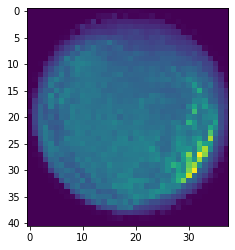

In [362]:

mat_Im=mat_contents["ImGrayEch"]
print(mat_Im.shape)
mat_Im=mat_Im[:,:,:6000]


plt.imshow(mat_Im[:,:,8])
minv=mat_Im[:,:,1].min()
print(mat_Im.shape)



In [363]:

from matplotlib import pyplot as plt


In [364]:
#DateTimeCom=DateTimeCom[:13100]



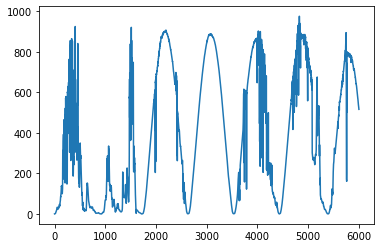

In [365]:
ghiset=mat_contents["GHI"]
#dni=mat_contents["DNI"]


ghiset=ghiset[:6000]

max(ghiset)
plt.plot(ghiset)

In [366]:
dataset_orig=mat_Im.reshape(mat_Im.shape[0]*mat_Im.shape[1],mat_Im.shape[2])




In [367]:

#dataset_orig=dataset_orig[:,:13100]


#dataset_orig=dataset_orig[:,::4]


from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

ghiset=scaler.fit_transform(ghiset)

#df_test['scaled_GHI'] = scaler.fit_transform(np.array(df_test['GHI']).reshape(-1, 1))



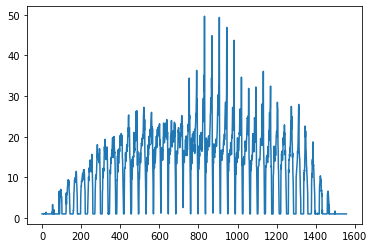

In [368]:
plt.plot(dataset_orig[:,1])
train_size=int(dataset_orig.shape[1]*.95)


In [369]:
#days_data=DateTimeCom.day

#Udays=np.unique(days_data)
#Udays

#cond=days_data.isin(Udays[12:13]) 
#Ind_test=np.where(cond== True)
#Ind_train=np.where(cond == False)


#plt.plot(ghiset[Ind_test])



In [370]:

data_train=dataset[:,:train_size]
data_test=dataset[:,train_size:]
data_train=data_train.T
data_test=data_test.T
ghiset_train=ghiset[:train_size]
ghiset_test=ghiset[train_size:]

In [371]:
data_train.shape,ghiset_train.shape

#train_size

((5700, 1558), (5700, 1))

In [372]:
dimInput=1
X_train, y_train = data_train,ghiset_train
X_val, y_val = data_test,ghiset_test

In [373]:
X_val.shape,y_val.shape,X_train.shape,y_train.shape


((300, 1558), (300, 1), (5700, 1558), (5700, 1))

In [374]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [375]:
#definition des entrées. None indicates the number of instances
input_layer = Input(shape=(1558,), dtype='float32')

In [376]:
#Les couches Denses avec une fonction d'activation relu
dense1 = Dense(300, activation='relu')(input_layer)
dropout_layer = Dropout(0.1)(dense1)


dense2 = Dense(300, activation='relu')(dense1)
dropout_layer = Dropout(0.1)(dense2)


dense3 = Dense(129, activation='relu')(dense2)
dropout_layer = Dropout(0.1)(dense3)

#dense4 = Dense(64, activation='relu')(dense3)
#dropout_layer = Dropout(0.1)(dense4)


#dense5 = Dense(16, activation='relu')(dense4)
#dropout_layer = Dropout(0.1)(dense5)




In [377]:
output_layer = Dense(1, activation='relu')(dropout_layer)


In [378]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')

ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1558)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 300)               467700    
_________________________________________________________________
dense_100 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_101 (Dense)            (None, 129)               38829     
_________________________________________________________________
dropout_79 (Dropout)         (None, 129)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 130       
Total params: 596,959
Trainable params: 596,959
Non-trainable params: 0
_________________________________________________________________


In [379]:
save_weights_at = os.path.join(path, 'CamGHI_MLP_poids.{epoch:02d}-{val_loss:.4f}.hdf5')
print(save_weights_at)

/Users/hanany/Documents/SkyImageGlobalHorizontalIrradiation/CamGHI_MLP_poids.{epoch:02d}-{val_loss:.4f}.hdf5


In [380]:
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)


In [381]:
ts_model.fit(x=X_train, y=y_train, batch_size=100, epochs=50,verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
           shuffle=True)


Train on 5700 samples, validate on 300 samples
Epoch 1/50
5700/5700 [==============================] - 19s 3ms/step - loss: 0.0616 - val_loss: 0.0272
Epoch 2/50
5700/5700 [==============================] - 8s 1ms/step - loss: 0.0133 - val_loss: 0.0381
Epoch 3/50
5700/5700 [==============================] - 6s 1ms/step - loss: 0.0103 - val_loss: 0.0264
Epoch 4/50
5700/5700 [==============================] - 6s 999us/step - loss: 0.0095 - val_loss: 0.0436
Epoch 5/50
5700/5700 [==============================] - 5s 943us/step - loss: 0.0098 - val_loss: 0.0577
Epoch 6/50
5700/5700 [==============================] - 8s 1ms/step - loss: 0.0104 - val_loss: 0.0337
Epoch 7/50
5700/5700 [==============================] - 6s 1ms/step - loss: 0.0067 - val_loss: 0.0256
Epoch 8/50
5700/5700 [==============================] - 8s 1ms/step - loss: 0.0050 - val_loss: 0.0252
Epoch 9/50
5700/5700 [==============================] - 14s 2ms/step - loss: 0.0045 - val_loss: 0.0209
Epoch 10/50
5700/5700 [======

m

In [382]:
files = sorted(os.listdir(path), key=os.path.getctime)

oldest = files[0]
newest = files[-2]
print(newest)

CamGHI_MLP_poids.30-0.0085.hdf5


In [383]:
os.path.join(path,newest)

'/Users/hanany/Documents/SkyImageGlobalHorizontalIrradiation/CamGHI_MLP_poids.30-0.0085.hdf5'

In [384]:
best_model = load_model(os.path.join(path,newest))
preds = best_model.predict(X_val)
pred_PRES = preds
pred_PRES = np.squeeze(pred_PRES)


from sklearn.metrics import r2_score,mean_squared_error
r2 = r2_score(y_val, pred_PRES)

#print('R-squared for the validation set:'.format(r2))
print("R-squared en test  est {} ".format(r2))

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(y_val, pred_PRES))
print("L'erreur en test  est {} (nRMSE)".format(testScore))



R-squared en test  est 0.4737891830563231 
L'erreur en test  est 0.09210205376708645 (nRMSE)


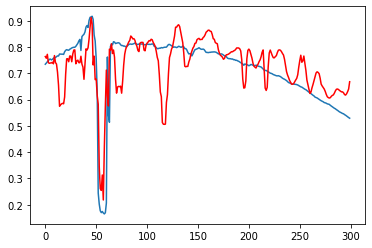

In [385]:
ghi_est=pred_PRES

ghi_true=y_val

plt.plot(ghi_true)
plt.plot(ghi_est,'r')



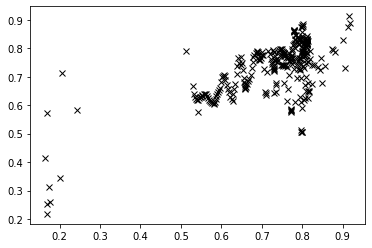

In [386]:
plt.plot(ghi_true,ghi_est,'kx')



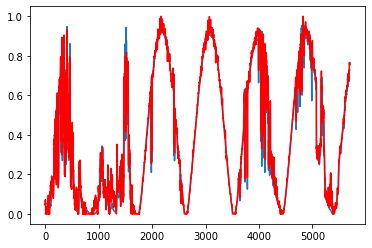

In [387]:
fits = best_model.predict(X_train)

plt.plot(y_train)
plt.plot(fits,'r')
plt.show()


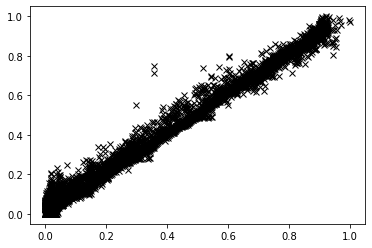

In [388]:
plt.plot(y_train,fits,'kx')



(1, 728)

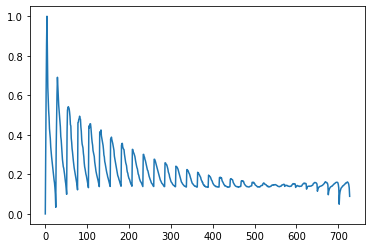